In [1]:
# !pip install matplotlib

In [2]:
import csv
from dataclasses import dataclass, field, asdict, astuple
from typing import List
import math
import matplotlib.pyplot as plt

In [3]:
def importCSV(_path):
    with open(_path,'r') as f:
        reader  = csv.reader(f) # csv의 행별로 읽어옴

        res = [x for x in reader]
    return res

In [4]:
def exportCSV(_filename, _datas):
    f = open(_filename, 'w', newline='') # 자동줄바꿈 방지 header 이후 첫행 빈행 생성 방지
    csv_writer = csv.writer(f)
    
    for x in _datas:
        csv_writer.writerow(x)
    f.close()

# AISC 360-16 Chapter F
# Design of Members for Flexure

<br>

## 단면 정보 import

In [5]:
input_path = 'Section Profile.csv'

In [6]:
dfSectionProfile = importCSV(input_path)
dfHeader = dfSectionProfile.pop(0) #pop(0)의 의미 첫행을 값을 반환하고 나머지 리스트는 저장

In [7]:
@dataclass # @의 의미 데코레이터 C언어의 Struct와 비슷한 쓰임새, 각 항목의 data 특성값 부여
class SectionForm:
    ID: str
    shape: str
    h: str
    bf: str
    tw: str
    tf: str
    k: str
    
section1 = SectionForm(*dfSectionProfile[294]) ##결과 확인용 코드

sections = [SectionForm(*x) for x in dfSectionProfile] ##결과 확인용 코드

sections ##결과 확인용 코드

[SectionForm(ID='W44X335', shape='W', h='1120', bf='404', tw='26.2', tf='45', k='65'),
 SectionForm(ID='W44X290', shape='W', h='1110', bf='401', tw='22', tf='40.1', k='59.9'),
 SectionForm(ID='W44X262', shape='W', h='1100', bf='401', tw='19.9', tf='36.1', k='55.9'),
 SectionForm(ID='W44X230', shape='W', h='1090', bf='401', tw='18', tf='31', k='51.1'),
 SectionForm(ID='W40X655', shape='W', h='1110', bf='429', tw='50', tf='89.9', k='120'),
 SectionForm(ID='W40X593', shape='W', h='1090', bf='424', tw='45.5', tf='82', k='112'),
 SectionForm(ID='W40X503', shape='W', h='1070', bf='417', tw='39.1', tf='70.1', k='100'),
 SectionForm(ID='W40X431', shape='W', h='1050', bf='411', tw='34', tf='59.9', k='89.9'),
 SectionForm(ID='W40X397', shape='W', h='1040', bf='409', tw='31', tf='55.9', k='85.9'),
 SectionForm(ID='W40X372', shape='W', h='1030', bf='409', tw='29.5', tf='52.1', k='82'),
 SectionForm(ID='W40X362', shape='W', h='1030', bf='406', tw='28.4', tf='51.1', k='81'),
 SectionForm(ID='W40X324

In [8]:
targetSection = SectionForm(*dfSectionProfile[160])
# vec1 = [18, 7.5, 0.355, 0.57, 0.972]
# vec2 = list(map(lambda x: x*0.083, vec1))
# (targetSection.h, targetSection.bf, targetSection.tw, targetSection.tf, targetSection.k) = vec1

targetSection

SectionForm(ID='W18X50', shape='W', h='457', bf='191', tw='9.02', tf='14.5', k='24.7')

<br><br><br>
## 0. 재료 속성 Handler

In [9]:
## 클래스 선언부

class MaterialHandler:
    """Regist Fy and E"""
    fy = 0
    E = 0
    
    def registValue(self, fy, E):
        self.fy = fy
        self.E = E
    def getAttribute(self):
        return (self.fy, self.E)

In [10]:
## 사용 예시

####### 사용자 입력부 #######
input_fy = 344.738 ## 50
input_E = 199900 ## 29000
#############################

matHandler = MaterialHandler() ## 재료핸들러 객체 생성
matHandler.registValue(input_fy, input_E)
matHandler.getAttribute()
matHandler.fy

344.738

<br><br><br>
## 1. 단면 속성 Handler

In [11]:
## 클래스 선언부

class SectionHandler:
    def __init__(self, matHandler:MaterialHandler, sectForm:SectionForm):
        (self.fy, self.E) = matHandler.getAttribute()
        
        self.ID = sectForm.ID
        ( self.h, self.bf ) = ( float(sectForm.h), float(sectForm.bf) )
        ( self.tw, self.tf ) = ( float(sectForm.tw), float(sectForm.tf) )
        self.k = float(sectForm.k)
        self.shape = sectForm.shape

        self.Area = 2*self.tf*self.bf+(self.h-2*self.tf)*self.tw
        self.Weight = self.Area*77.22/10**6
        self.Ix = (2*(self.bf*self.tf**3/12+self.bf*self.tf*((self.h-2*self.tf)/2+self.tf/2)**2)+self.tw*(self.h-2*self.tf)**3/12) ## 단면2차모멘트
        self.Sx = self.Ix/(self.h/2) ## 탄성단면계수
        self.Zx = self.bf*self.tf*(self.h-self.tf)+0.25*(self.h-2*self.tf)**2*self.tw ## 소성단면계수
        self.rx = (self.Ix/self.Area)**0.5 ## 회전반경
        self.Iy = 2*(self.tf*(self.bf)**3/12)+(self.h-2*self.tf)*(self.tw)**3/12
        self.Sy = self.Iy/(self.bf/2)
        self.Zy = 0.5*(self.bf)**2*self.tf+0.25*(self.h-2*self.tf)*(self.tw)**2
        self.ry = (self.Iy/self.Area)**0.5
        self.Cw = (self.h-self.tf)**2*self.bf**3*self.tf/24 ## 뒤틀림 상수(mm6)
        self.J = (2*self.bf*self.tf**3+(self.h-self.tf)*self.tw**3)/3 ## 비틀림 상수(mm4)
        self.rts = ((self.Iy*self.Cw)**0.5/self.Sx)**0.5
        self.h0 = self.h - self.tf
        self.C = self.defineC()
        
    def defineC(self):
        if self.shape == "W" or self.shape == "H":
            return 1
        elif self.shape == "C":
            return (self.h0/2) * (self.Iy/self.Cw)**0.5
        else:
            return 1 ## 임시 대처
                

        
    def __repr__(self):
        return str(
            [self.ID,
            self.shape,
            self.Area,
            self.Weight,
            ]
        )

In [12]:
## 사용 예시

sectHandler = SectionHandler(matHandler, targetSection) ## 재료핸들러와 단면 데이터 입력하여 섹션핸들러 개체 생성
print(sectHandler)

['W18X50', 'W', 9399.56, 0.7258340231999999]


## 2. Design Base Handler

In [13]:
## 클래스 선언부

class DesignBaseHandler:
    """design base data"""
    def __init__(self, _shd:SectionHandler):
        (self.fy, self.E) = (_shd.fy, _shd.E)
        self.shape = _shd.shape
        self._shd = _shd
    
    def registLoad(self, DL, LL):
        self.DL = DL
        self.LL = LL
        
    def registLength(self, length):
        self.length = length
        
    def registLb(self, Lb):
        self.Lb = Lb


## 3. Design Checker

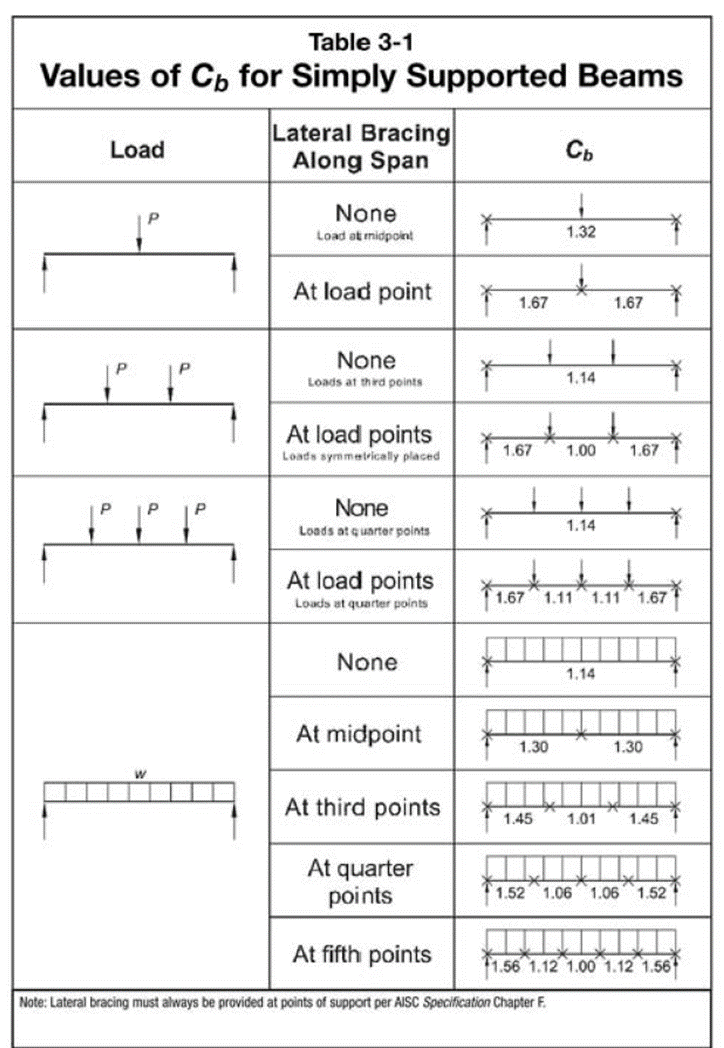

In [15]:
## 클래스 선언부

class LtbHandler:
    """lateral-torsional buckling"""
    def __init__(self, mode, brace_idx): ## mode = "1p", "2p", "3p", "continuous"
        self.mode = mode
        self.brace_idx = brace_idx
        
    def findCb(self):
        _none = {
            "1p": [1.32],
            "2p": [1.14],
            "3p": [1.14],
            "continuous": [1.14],
        }
        
        _atLoad = {
            "1p": [[1.67, 1.67]],
            "2p": [[1.67, 1.00, 1.67]],
            "3p": [[1.67, 1.11, 1.11, 1.67]],
            "continuous": [
                [1.30, 1.30], 
                [1.45, 1.01, 1.45], 
                [1.52, 1.06, 1.06, 1.52], 
                [1.56, 1.12, 1.00, 1.12, 1.56]
            ],
        }
        if self.brace_idx == 0:
            result = _none[self.mode][self.brace_idx]
        else:
            result = _atLoad[self.mode][self.brace_idx-1]
        
        return result
        

In [65]:
## 사용 예시
##### 몇번 지지 되었나요? #####
div_No  = 1
############################
ltbHandler = LtbHandler("continuous", div_No)
ltbHandler.findCb()

[1.3, 1.3]

In [66]:
## 사용 예시

baseHandler = DesignBaseHandler(sectHandler) ## 섹션핸들러 입력하여 디자인베이스핸들러 개체 생성
baseHandler.registLoad(6.567, 10.945)
baseHandler.registLength(10670)
baseHandler.registLb(baseHandler.length/(divNo+1))

baseHandler.Lb

5335.0

In [71]:
## 클래스 선언부

class DesignChecker:
    """Check the member design result"""
    def __init__(self, _bhd:DesignBaseHandler, _lhd:LtbHandler):
        (self.fy, self.E) = (_bhd.fy, _bhd.E)
        self.shape = _bhd.shape
        self.Lp = self.findLp(_bhd._shd)
        self.Lr = self.findLr(_bhd._shd)
        self._bhd = _bhd
        self._shd = _bhd._shd
        self.DL = _bhd.DL
        self.LL = _bhd.LL
        self.length = _bhd.length
        self.Mp = self.findMp(_bhd._shd)
        self.Cb = _lhd.findCb()
        self.Mn = self.findMn(_bhd._shd)

    def findLp(self, _shd:SectionHandler):
        return 1.76 * _shd.ry * (_shd.E/_shd.fy)**0.5
    
    def findLr(self, _shd:SectionHandler):
        return 1.95*_shd.rts*_shd.E/(0.7*_shd.fy)*(_shd.J/(_shd.Sx*(_shd.h0))+((_shd.J/(_shd.Sx*(_shd.h0)))**2+6.76*(0.7*_shd.fy/_shd.E)**2)**0.5)**0.5
    
    def findMp(self, _shd:SectionHandler):
        ### for Strong Axis ###
        Mp_x = _shd.fy * _shd.Zx
        
        ### for Weak Axis ###
        Mp_y = min([(_shd.fy * _shd.Zy), (1.6*_shd.fy*_shd.Sy)])
        
        return {"Mp_x": Mp_x, "Mp_y": Mp_y}
    
    def findMn(self, _shd:SectionHandler): ### for Strong Axis ###
        Mp = self.Mp["Mp_x"]
        if self._bhd.Lb <= self.Lp:
            Mn = Mp
        elif self.Lp < self._bhd.Lb <= self.Lr:
            Mn = min(map(lambda x: x * (Mp-(Mp-0.7*_shd.fy*_shd.Sx)*((self._bhd.Lb-self.Lp) / (self.Lr-self.Lp))), self.Cb))
        elif self._bhd.Lb > self.Lr:
            Fcr = min(map(lambda x: (x * (math.pi**2 * self.E)/(self._bhd.Lb/_shd.rts)**2) * (1 + 0.078*(_shd.J*_shd.C/_shd.Sx*_shd.h0)*(self._bhd.Lb/_shd.rts)**2)**0.5 ,self.Cb))
            Mn = Fcr*_shd.Sx <= Mp
        
        return Mn / 1000**2


    def calcRequired(self, mode):
        def calcStr(mode):
            if mode == "LRFD":
                result = 1.2*self.DL + 1.6*self.LL
            elif mode == "ASD":
                result == self.DL + self.LL
            return result
        
        def calcMoment(mode):
            result = ((calcStr(mode) * self.length**2) / 8) / 1000**2
            return result
        
        return (calcStr(mode), calcMoment(mode))
    

In [72]:
## 사용 예시

chkHandler = DesignChecker(baseHandler,ltbHandler)
chkHandler.Lp
chkHandler.Lr
chkHandler.calcRequired("LRFD")
chkHandler.Mp
chkHandler.Mn * 0.9
chkHandler.Cb

[1.3, 1.3]

---
=================================================================================================================

## EXAMPLE F.1-1A W-SHAPE FLEXURAL MEMBER DESIGN IN MAJOR AXIS BENDING, CONTINUOUSLY BRACED

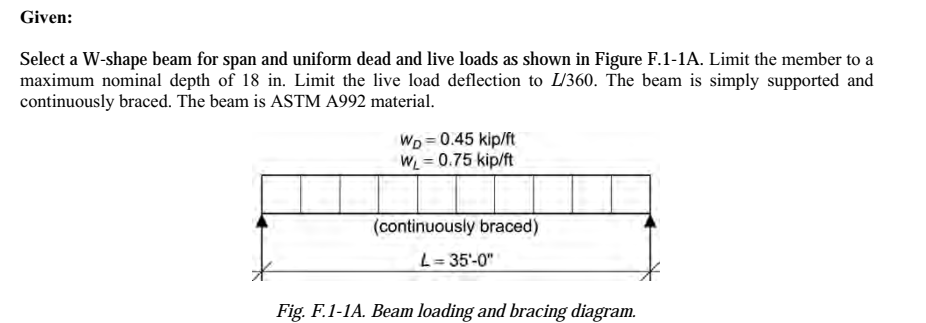

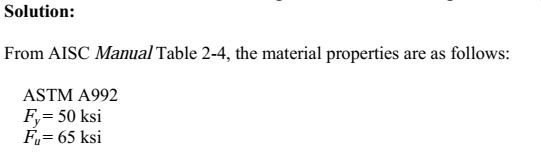

In [61]:
## 사용 예시

####### 사용자 입력부 #######
input_fy = 344.738
input_E = 199900
#############################

matHandler = MaterialHandler() ## 재료핸들러 객체 생성
matHandler.registValue(input_fy, input_E)
matHandler.getAttribute()
matHandler.fy

344.738

In [62]:
## 검토대상 단면 설정

targetSection = SectionForm(*dfSectionProfile[160])
targetSection

SectionForm(ID='W18X50', shape='W', h='457', bf='191', tw='9.02', tf='14.5', k='24.7')

In [63]:
## 사용 예시

sectHandler = SectionHandler(matHandler, targetSection) ## 재료핸들러와 단면 데이터 입력하여 섹션핸들러 개체 생성
print(sectHandler)

['W18X50', 'W', 9399.56, 0.7258340231999999]


In [64]:
## 사용 예시

baseHandler = DesignBaseHandler(sectHandler) ## 섹션핸들러 입력하여 디자인베이스핸들러 개체 생성
baseHandler.registLoad(6.567, 10.945)
baseHandler.registLength(10670)
baseHandler.registLb(baseHandler.length/3)

baseHandler.Lb

3556.6666666666665